## Final Project for Data 605 - Big data systems
- Name: Mohammed Ateeq Ur Rehman
- UID: 120872334

In [1]:
%pip install petastorm pyarrow pandas matplotlib torch torchvision tensorflow fastparquet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import time
import pandas as pd
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import petastorm_bitcoin_processing_utils as utils
import pyarrow.parquet as pq

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from petastorm import make_batch_reader
from petastorm.unischema import Unischema, UnischemaField
from petastorm.codecs import ScalarCodec
from petastorm.etl.dataset_metadata import materialize_dataset
from petastorm import make_batch_reader


2025-05-18 10:58:14.089470: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 10:58:14.127947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 10:58:14.129432: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-18 10:58:14.994481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data Ingestion

In [3]:
output_dir = 'test_bitcoin_data'
os.makedirs(output_dir, exist_ok=True)

base_url = "https://api.coingecko.com/api/v3"
historical_data = []

In [4]:
# Parameters
interval_sec = 30  # every 30 seconds
duration_min = 1   # run for 1 minute
save_interval = 2  # save every 2 fetches

end_time = time.time() + duration_min * 60
fetch_count = 0
historical_data = []

output_file = os.path.join(output_dir, "bitcoin_price_data.csv")

while time.time() < end_time:
    try:
        price_data = utils.fetch_current_price(base_url)
        historical_data.append(price_data)
        fetch_count += 1
        print(f"Collected data at {price_data['timestamp']}")

        # Save to file every `save_interval` fetches
        if fetch_count % save_interval == 0:
            new_df = pd.DataFrame(historical_data)
            historical_data = []  # clear buffer after saving

            # Append to existing file or create new one
            if os.path.exists(output_file):
                new_df.to_csv(output_file, mode='a', header=False, index=False)
            else:
                new_df.to_csv(output_file, mode='w', header=True, index=False)

    except Exception as e:
        print(f"Error fetching data: {e}")
        break  # Use break instead of exit in notebooks/scripts

    time.sleep(interval_sec)
print("Data collection complete.")

Collected data at 2025-05-18T10:58:16.600969
Collected data at 2025-05-18T10:58:46.587055
Data collection complete.


### Data Storage

In [6]:
# 1. Load all price CSVs
csv_folder = r"test_bitcoin_data"
df = utils.load_all_csvs_from_folder(csv_folder)

# 2. Save to Parquet
parquet_path = "file:///test_bitcoin_data/parquet"
utils.save_to_parquet_arrow(df, parquet_path)

# 3. Load from Parquet and preview
batches = list(utils.load_from_parquet(input_dir='test_bitcoin_data/parquet'))


Combined 3 CSV files.
======== Parquet file written to 
 /data/test_bitcoin_data/parquet ==========
Loading data from file:///data/test_bitcoin_data/parquet...


In [7]:
parquet_path = "test_bitcoin_data/parquet/data.parquet"
table = pq.read_table(parquet_path)
schema_columns = table.column_names
print("Columns:", table.column_names)


Columns: ['timestamp', 'price_usd', 'market_cap', 'price_change_24h']


In [8]:
for batch in batches[:1]:
    df = pd.DataFrame(batch)
    print(df.head())


                   0                    1                    2    \
0  2025-05-17T00:00:00  2025-05-16T00:00:00  2025-05-15T00:00:00   
1            103053.98            103489.29            103744.64   
2   3908612516821320.0   4593527304765811.0   5229584902723738.0   
3               -441.8              -246.37               205.81   

                   3                    4                    5    \
0  2025-05-14T00:00:00  2025-05-13T00:00:00  2025-05-12T00:00:00   
1            103539.41            104169.81            102812.95   
2   4758264493306719.0   5480256659943182.0   6502967965187682.0   
3              -627.92              1357.32             -1294.01   

                   6                    7                    8    \
0  2025-05-11T00:00:00  2025-05-10T00:00:00  2025-05-09T00:00:00   
1            104106.36            104696.33            102970.85   
2   4818616737855302.0   4426216799631441.5   5992758688660125.0   
3              -594.71              1722.62   

### Data Processing


=== Bitcoin Price Analysis Report ===
Time Period: 2024-05-17 00:00:00 to 2025-05-17 00:00:00
Number of Data Points: 366

Price Statistics:
count       366.000000
mean      79236.452049
std       16139.550269
min       53948.750000
25%       64197.387500
50%       80537.615000
75%       95723.690000
max      106146.270000
Name: price_usd, dtype: float64

Latest Price: $103,053.98
24h Change: -441.80%


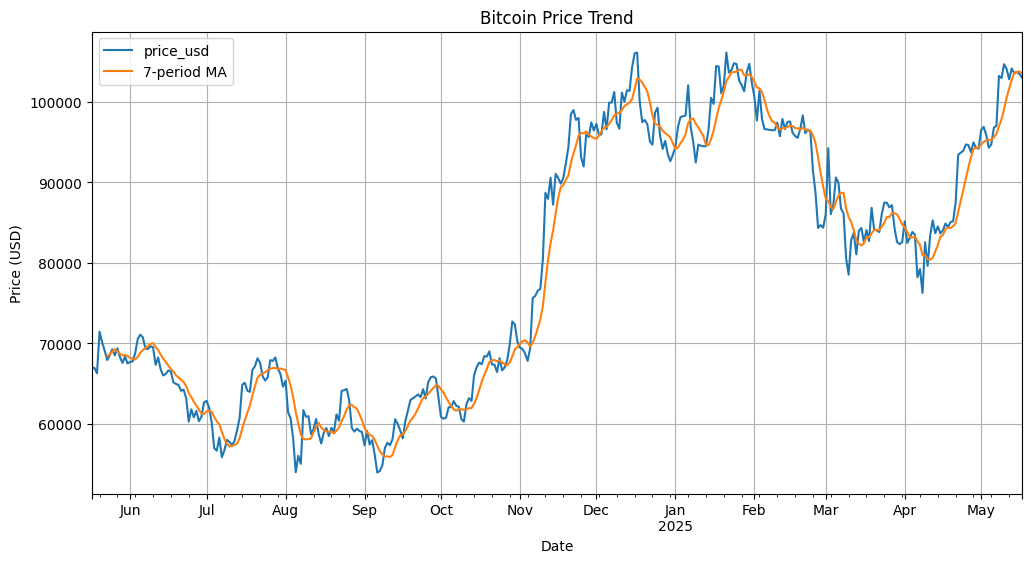

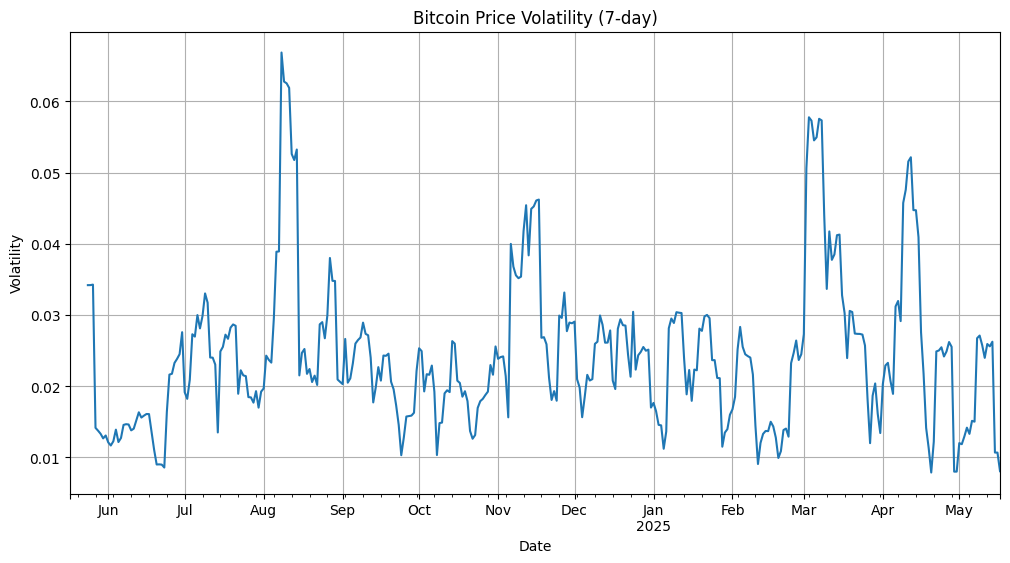

In [11]:
# Load → Prepare → Report
df = pd.read_parquet("test_bitcoin_data/parquet/data.parquet")
df = utils.prepare_bitcoin_df(df,)
utils.generate_report(df)


### ML Integration

In [12]:
# --- Global scaler ---
scaler = MinMaxScaler(feature_range=(0, 1))


# --- Load and Prepare Data ---
def load_and_prepare_data_from_parquet(file_path, look_back=10, test_size=0.2):
    df = pd.read_parquet(file_path)
    
    if 'price_usd' not in df.columns:
        raise ValueError("'price_usd' column is missing.")
    
    prices = df['price_usd'].values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(prices)

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i - look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    split = int(len(X) * (1 - test_size))
    # print(X[:split], X[split:], y[:split], y[split:], scaler)
    return X[:split], X[split:], y[:split], y[split:], scaler


# --- Build LSTM Model ---
def build_lstm_model(look_back):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(50, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model


# --- Train and Evaluate ---
def train_and_evaluate(data_path, look_back=10, epochs=50, batch_size=8):
    X_train, X_test, y_train, y_test, scaler = load_and_prepare_data_from_parquet(data_path, look_back)

    model = build_lstm_model(look_back)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              validation_data=(X_test, y_test))

    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Inverse scaling
    train_predict = scaler.inverse_transform(train_predict)
    y_train_orig = scaler.inverse_transform([y_train])
    test_predict = scaler.inverse_transform(test_predict)
    y_test_orig = scaler.inverse_transform([y_test])

    # Evaluate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train_orig[0], train_predict[:, 0]))
    test_rmse = np.sqrt(mean_squared_error(y_test_orig[0], test_predict[:, 0]))

    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")

        # === Plot Training Curves ===
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model, train_predict, test_predict

In [13]:
import pandas as pd
df = pd.read_parquet("test_bitcoin_data/parquet")
print(f"Data has {len(df)} rows")


Data has 382 rows


2025-05-18 11:04:35.682838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-18 11:04:35.685021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-18 11:04:35.686338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2025-05-18 11:04:36.137100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-18 11:04:36.138720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-18 11:04:36.140507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/38 [======================>.......] - ETA: 0s - loss: 0.0578 - mae: 0.1678

2025-05-18 11:04:38.812645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-18 11:04:38.814156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-18 11:04:38.815679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - 3s 22ms/step - loss: 0.0491 - mae: 0.1540 - val_loss: 0.0270 - val_mae: 0.0975
Epoch 2/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0109 - mae: 0.0803 - val_loss: 0.0296 - val_mae: 0.0959
Epoch 3/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0092 - mae: 0.0748 - val_loss: 0.0308 - val_mae: 0.1003
Epoch 4/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0091 - mae: 0.0725 - val_loss: 0.0278 - val_mae: 0.0912
Epoch 5/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0089 - mae: 0.0732 - val_loss: 0.0250 - val_mae: 0.0828
Epoch 6/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0097 - mae: 0.0748 - val_loss: 0.0238 - val_mae: 0.0813
Epoch 7/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0087 - mae: 0.0721 - val_loss: 0.0346 - val_mae: 0.1162
Epoch 8/50
38/38 [==============================] - 0s 7ms/step - loss: 0.0095 - mae: 0.0768 - val_l

2025-05-18 11:04:52.275926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-18 11:04:52.277768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-18 11:04:52.278929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 3ms/step
Train RMSE: 2827.97
Test RMSE: 5618.72


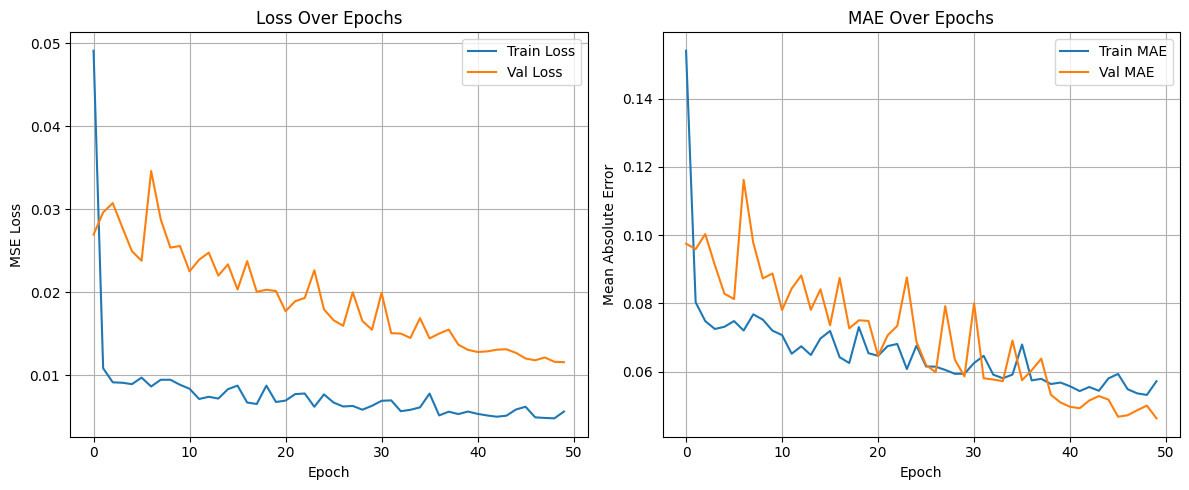

In [14]:
data_path = "test_bitcoin_data/parquet"
model, train_pred, test_pred = train_and_evaluate(data_path, look_back=10, epochs=50, batch_size=8)